### 1. Preprocessing and resampling

In [85]:
import os

import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.ndimage as nd
import SimpleITK as sitk
from scipy import ndimage
from skimage import color, exposure, measure, morphology
from skimage.morphology import disk, dilation
from tiatoolbox.models.engine.semantic_segmentor import SemanticSegmentor
from tiatoolbox.tools.registration.wsi_registration import match_histograms

In [77]:
csv_path = "/data/dataset_medium.csv"
dataset_path = "/data/ANHIR_Data"
output_path = "/data/ANHIR_Parsed_1024_Masks_EXPERIMENTS"
output_max_size = 1024
current_id = 214
max_size = 1024

In [78]:
segmentor = SemanticSegmentor(
	pretrained_model="unet_tissue_mask_tsef",
	num_loader_workers=4,
	batch_size=4,
)

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/registration/UNET-v0.0-TSEF.pth
Save to /home/ivan/.tiatoolbox/models/UNET-v0.0-TSEF.pth


In [126]:
def load_pair(case_id, dataset_path, load_masks=False):
    base_path = os.path.join(dataset_path, str(case_id))
    source_path = os.path.join(base_path, "source.mha")
    target_path = os.path.join(base_path, "target.mha")
    if load_masks:
        source_mask_path = os.path.join(base_path, "source_mask.mha")
        target_mask_path = os.path.join(base_path, "target_mask.mha")
    source_landmarks_path = os.path.join(base_path, "source_landmarks.csv")
    target_landmarks_path = os.path.join(base_path, "target_landmarks.csv")

    source = sitk.GetArrayFromImage(sitk.ReadImage(source_path))
    target = sitk.GetArrayFromImage(sitk.ReadImage(target_path))
    if load_masks:
        source_mask = sitk.GetArrayFromImage(sitk.ReadImage(source_mask_path))
        target_mask = sitk.GetArrayFromImage(sitk.ReadImage(target_mask_path))
    source_landmarks = pd.read_csv(source_landmarks_path).to_numpy()[:, 1:]
    try:
        status = "training"
        target_landmarks = pd.read_csv(target_landmarks_path).to_numpy()[:, 1:]
    except:
        status = "evaluation"
        target_landmarks = None
    if load_masks:
        return source, target, source_landmarks, target_landmarks, status, source_mask, target_mask
    else:
        return source, target, source_landmarks, target_landmarks, status,


def resample_image(image, resample_ratio):
    y_size, x_size = image.shape
    new_y_size, new_x_size = int(y_size / resample_ratio), int(x_size / resample_ratio)
    grid_x, grid_y = np.meshgrid(np.arange(new_x_size), np.arange(new_y_size))
    grid_x = grid_x * (x_size / new_x_size)
    grid_y = grid_y * (y_size / new_y_size)
    resampled_image = nd.map_coordinates(image, [grid_y, grid_x], cval=0, order=3)
    return resampled_image


def normalize(image):
    min_val = np.min(image, axis=(0, 1))
    max_val = np.max(image, axis=(0, 1))
    return np.where(max_val != min_val, (image - min_val) / (max_val - min_val), image)


def load_landmarks(landmarks_path):
    landmarks = pd.read_csv(landmarks_path)
    landmarks = landmarks.to_numpy()[:, 1:]
    return landmarks


def pad_landmarks(landmarks, old_shape, new_shape):
    new_landmarks = landmarks.copy()
    new_landmarks[:, 0] += int(np.floor((new_shape[1] - old_shape[1])/2))
    new_landmarks[:, 1] += int(np.floor((new_shape[0] - old_shape[0])/2))
    return new_landmarks


def pad_single(image, new_shape):
    y_size, x_size = image.shape
    y_pad = ((int(np.floor((new_shape[0] - y_size)/2))), int(np.ceil((new_shape[0] - y_size)/2)))
    x_pad = ((int(np.floor((new_shape[1] - x_size)/2))), int(np.ceil((new_shape[1] - x_size)/2)))
    new_image = np.pad(image, (y_pad, x_pad), mode="constant", constant_values=0)
    return new_image


def pad_images_np(source, target):
    y_size_source, x_size_source = source.shape
    y_size_target, x_size_target = target.shape
    new_y_size = max(y_size_source, y_size_target)
    new_x_size = max(x_size_source, x_size_target)
    new_shape = (new_y_size, new_x_size)

    padded_source = pad_single(source, new_shape)
    padded_target = pad_single(target, new_shape)
    return padded_source, padded_target


def resample_landmarks(landmarks, resample_ratio):
    new_landmarks = landmarks / resample_ratio
    return new_landmarks


def save_landmarks(landmarks, landmarks_path):
    df = pd.DataFrame(landmarks)
    df.to_csv(landmarks_path)


def preprocess_image(image):
  image = color.rgb2gray(image)
  image = exposure.rescale_intensity(image, in_range=tuple(np.percentile(image, (0.5, 99.5))))
  image = exposure.equalize_adapthist(image, clip_limit=0.03)
  image = image*255
  return image.astype(np.uint8)

# def post_processing_mask(mask):
#     mask = ndimage.binary_fill_holes(mask, structure=np.ones((3, 3))).astype(int)

#     # remove all the objects while keep the biggest object only
#     label_img = measure.label(mask)
#     if len(np.unique(label_img)) > 2:
#         regions = measure.regionprops(label_img)
#         mask = mask.astype(bool)
#         all_area = [i.area for i in regions]
#         second_max = max([i for i in all_area if i != max(all_area)])
#         mask = morphology.remove_small_objects(mask, min_size=second_max + 1)
#     return mask.astype(np.uint8)

from scipy.ndimage import binary_dilation, binary_erosion

def post_processing_mask(mask, dilation_iter=4, erosion_iter=2):
    mask = ndimage.binary_fill_holes(mask, structure=np.ones((3, 3))).astype(int)

    mask = ndimage.binary_closing(mask, structure=disk(3))

    # Dilation
    mask = binary_dilation(mask, iterations=dilation_iter)

    # Erosion
    mask = binary_erosion(mask, iterations=erosion_iter)

    # remove all the objects while keep the biggest object only
    label_img = measure.label(mask)
    if len(np.unique(label_img)) > 2:
        regions = measure.regionprops(label_img)
        mask = mask.astype(bool)
        all_area = [i.area for i in regions]
        second_max = max([i for i in all_area if i != max(all_area)])
        mask = morphology.remove_small_objects(mask, min_size=second_max + 1)
    return mask.astype(np.uint8)


# def post_processing_mask(mask):
#     mask = ndimage.binary_fill_holes(mask, structure=np.ones((3,3))).astype(int)

#     # Apply morphological closing
#     mask = ndimage.binary_closing(mask, structure=disk(3))

#     # Apply dilation to expand the mask towards the edges
#     mask = dilation(mask, disk(3))

#     # Remove all the objects while keep the biggest object only
#     label_img = measure.label(mask)
#     if len(np.unique(label_img)) > 2:
#         regions = measure.regionprops(label_img)
#         mask = mask.astype(bool)
#         all_area = [i.area for i in regions]
#         second_max = max([i for i in all_area if i != max(all_area)])
#         mask = morphology.remove_small_objects(mask, min_size=second_max + 1)
#     return mask.astype(np.uint8)



In [67]:
# def parse_dataset(csv_path, dataset_path, output_path, max_size=1024):
# 	csv_file = pd.read_csv(csv_path)
# 	for current_case in csv_file.iterrows():
# def parse_dataset(csv_path, dataset_path, output_path, case_id, max_size=1024):
csv_file = pd.read_csv(csv_path)
current_case = csv_file.loc[csv_file['Unnamed: 0'] == current_id].iloc[0]
# variables def.
size = current_case['Image size [pixels]']
diagonal = int(current_case['Image diagonal [pixels]'])
y_size, x_size = int(size.split(",")[0][1:]), int(size.split(",")[1][:-1])
source_path = current_case['Source image']
target_path = current_case['Target image']
source_landmarks_path = current_case['Source landmarks']
target_landmarks_path = current_case['Target landmarks']
status = current_case['status']

source_path = os.path.join(dataset_path, source_path)
target_path = os.path.join(dataset_path, target_path)
source_landmarks_path = os.path.join(dataset_path, source_landmarks_path)
target_landmarks_path = os.path.join(dataset_path, target_landmarks_path)

sample_output_path = os.path.join(output_path, str(current_id))
to_save_source_jpg_path = os.path.join(sample_output_path, "source.jpg")
to_save_target_jpg_path = os.path.join(sample_output_path, "target.jpg")
to_save_source_png_path = os.path.join(sample_output_path, "source.png")
to_save_source_mask_png_path = os.path.join(sample_output_path, "source_mask.png")
to_save_source_mask_jpg_path = os.path.join(sample_output_path, "source_mask.jpg")
to_save_source_mask_mha_path = os.path.join(sample_output_path, "source_mask.mha")
to_save_source_png_path = os.path.join(sample_output_path, "source.png")
to_save_target_mask_png_path = os.path.join(output_path, str(current_id), "target_mask.png")
to_save_target_mask_jpg_path = os.path.join(output_path, str(current_id), "target_mask.jpg")
to_save_target_mask_mha_path = os.path.join(output_path, str(current_id), "target_mask.mha")
to_save_target_png_path = os.path.join(sample_output_path, "target.png")
to_save_source_mha_path = os.path.join(sample_output_path, "source.mha")
to_save_target_mha_path = os.path.join(sample_output_path, "target.mha")
to_save_source_landmarks_path = os.path.join(sample_output_path, "source_landmarks.csv")
if status == "training":
	to_save_target_landmarks_path = os.path.join(sample_output_path, "target_landmarks.csv")

# loading
source_landmarks = load_landmarks(source_landmarks_path)

if status == "training":
	target_landmarks = load_landmarks(target_landmarks_path)

source = sitk.GetArrayFromImage(sitk.ReadImage(source_path))
target = sitk.GetArrayFromImage(sitk.ReadImage(target_path))

# preprocessing
source, target = preprocess_image(source), preprocess_image(target)

source, target = match_histograms(source, target)

source = 1 - source
target = 1 - target

padded_source, padded_target = pad_images_np(source, target)
padded_source_landmarks = pad_landmarks(source_landmarks, source.shape, padded_source.shape)

if status == "training":
	padded_target_landmarks = pad_landmarks(target_landmarks, target.shape, padded_target.shape)

# resampling
resample_factor = np.max(padded_source.shape) / max_size
gaussian_sigma = resample_factor / 1.25

smoothed_source = nd.gaussian_filter(padded_source, gaussian_sigma)
smoothed_target = nd.gaussian_filter(padded_target, gaussian_sigma)

resampled_source = resample_image(smoothed_source, resample_factor)
resampled_target = resample_image(smoothed_target, resample_factor)
resampled_source_landmarks = resample_landmarks(padded_source_landmarks, resample_factor)

if status == "training":
	resampled_target_landmarks = resample_landmarks(padded_target_landmarks, resample_factor)

# storage
if not os.path.isdir(os.path.dirname(os.path.join(output_path, str(current_id)))):
	os.makedirs(os.path.join(os.path.join(output_path, str(current_id))))

to_save_source_png = cv2.cvtColor(resampled_source, cv2.COLOR_GRAY2RGB)
to_save_target_png = cv2.cvtColor(resampled_target, cv2.COLOR_GRAY2RGB)
to_save_source_mha = sitk.GetImageFromArray(resampled_source)
to_save_target_mha = sitk.GetImageFromArray(resampled_target)
to_save_source_landmarks = resampled_source_landmarks.astype(np.float32)
if status == "training":
	to_save_target_landmarks = resampled_target_landmarks.astype(np.float32)

cv2.imwrite(to_save_source_png_path, to_save_source_png)
cv2.imwrite(to_save_target_png_path, to_save_target_png)
cv2.imwrite(to_save_source_jpg_path, to_save_source_png)
cv2.imwrite(to_save_target_jpg_path, to_save_target_png)
sitk.WriteImage(to_save_source_mha, to_save_source_mha_path)
sitk.WriteImage(to_save_target_mha, to_save_target_mha_path)
save_landmarks(to_save_source_landmarks, to_save_source_landmarks_path)
if status == "training":
	save_landmarks(to_save_target_landmarks, to_save_target_landmarks_path) 

In [127]:
# tissue segmentation
# if save_dir exists, remove
if os.path.isdir(os.path.join(sample_output_path, 'mask')):
    shutil.rmtree(os.path.join(sample_output_path, 'mask'))

output = segmentor.predict(
[to_save_source_png_path, to_save_target_png_path],
	save_dir=os.path.join(sample_output_path, 'mask'),
	mode="tile",
	resolution=1.0,
	units="baseline",
	patch_input_shape=[1024, 1024],
	patch_output_shape=[512, 512],
	stride_shape=[512, 512],
	on_gpu=True,
	crash_on_exception=True,
)

fixed_mask = np.load(output[0][1] + ".raw.0.npy")
moving_mask = np.load(output[1][1] + ".raw.0.npy")

fixed_mask = np.argmax(fixed_mask, axis=-1) == 2 
moving_mask = np.argmax(moving_mask, axis=-1) == 2  

fixed_mask = post_processing_mask(fixed_mask).astype(np.uint8) * 255
moving_mask = post_processing_mask(moving_mask).astype(np.uint8) * 255

cv2.imwrite(to_save_source_mask_png_path, fixed_mask)
cv2.imwrite(to_save_source_mask_jpg_path, fixed_mask)
cv2.imwrite(to_save_target_mask_png_path, moving_mask)
cv2.imwrite(to_save_target_mask_jpg_path, moving_mask)
sitk.WriteImage(sitk.GetImageFromArray(fixed_mask), to_save_source_mask_mha_path)
sitk.WriteImage(sitk.GetImageFromArray(moving_mask), to_save_target_mask_mha_path)

|2023-09-15|19:27:41.226| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
|2023-09-15|19:27:41.261| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
|2023-09-15|19:27:41.271| [WARNING] Raw data is None.
|2023-09-15|19:27:41.271| [WARNING] Unknown scale (no objective_power or mpp)
Process Batch: 100%|##############################| 1/1 [00:00<00:00,  1.72it/s]

|2023-09-15|19:27:41.858| [INFO] Finish: 0
|2023-09-15|19:27:41.858| [INFO] --Input: /data/ANHIR_Parsed_1024_Masks_EXPERIMENTS/214/source.png
|2023-09-15|19:27:41.858| [INFO] --Output: /data/ANHIR_Parsed_1024_Masks_EXPERIMENTS/214/mask/0



|2023-09-15|19:27:41.867| [WARNING] Raw data is None.
|2023-09-15|19:27:41.867| [WARNING] Unknown scale (no objective_power or mpp)
Process Batch: 100%|##############################| 1/1 [00:00<00:00,  2.14it/s]

|2023-09-15|19:27:42.339| [INFO] Finish: 0
|2023-09-15|19:27:42.339| [INFO] --Input: /data/ANHIR_Parsed_1024_Masks_EXPERIMENTS/214/target.png
|2023-09-15|19:27:42.340| [INFO] --Output: /data/ANHIR_Parsed_1024_Masks_EXPERIMENTS/214/mask/1


### 2. Get tissue mask

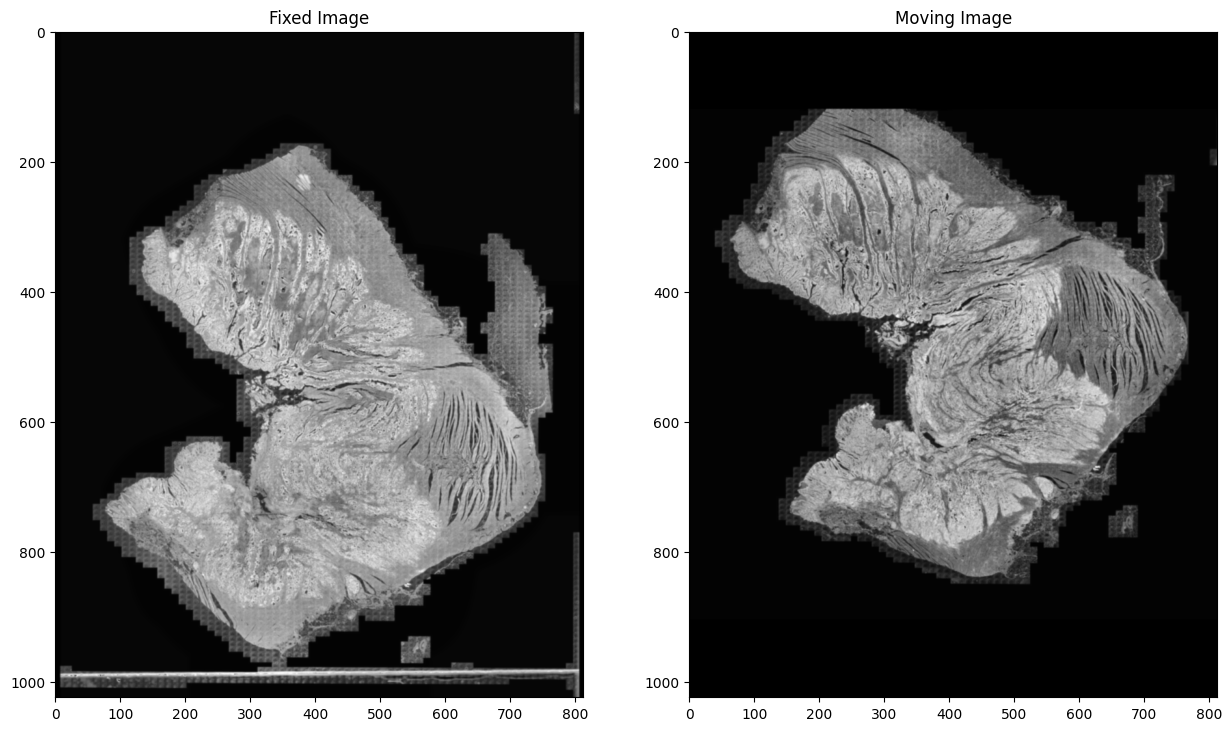

In [72]:
_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(resampled_source, cmap='gray')
axs[0].set_title("Fixed Image")
axs[1].imshow(resampled_target, cmap='gray')
axs[1].set_title("Moving Image")
plt.show()

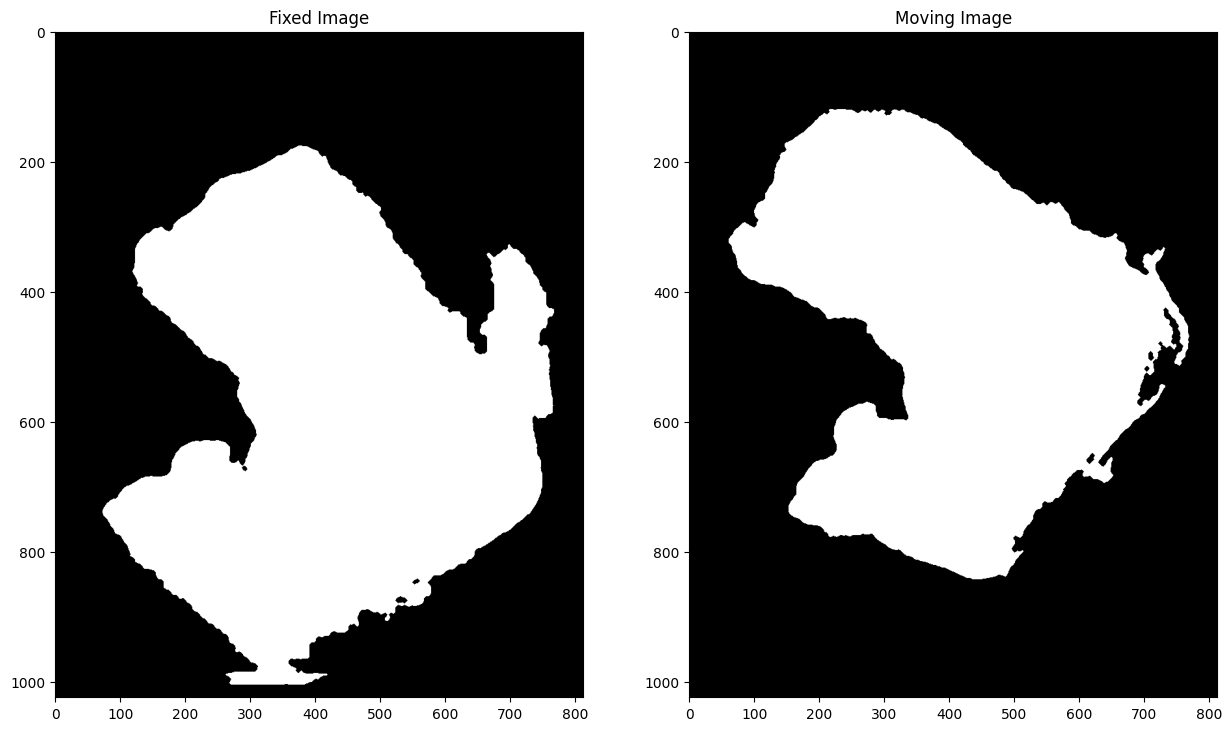

In [128]:
_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(fixed_mask, cmap='gray')
axs[0].set_title("Fixed Image")
axs[1].imshow(moving_mask, cmap='gray')
axs[1].set_title("Moving Image")
plt.show()

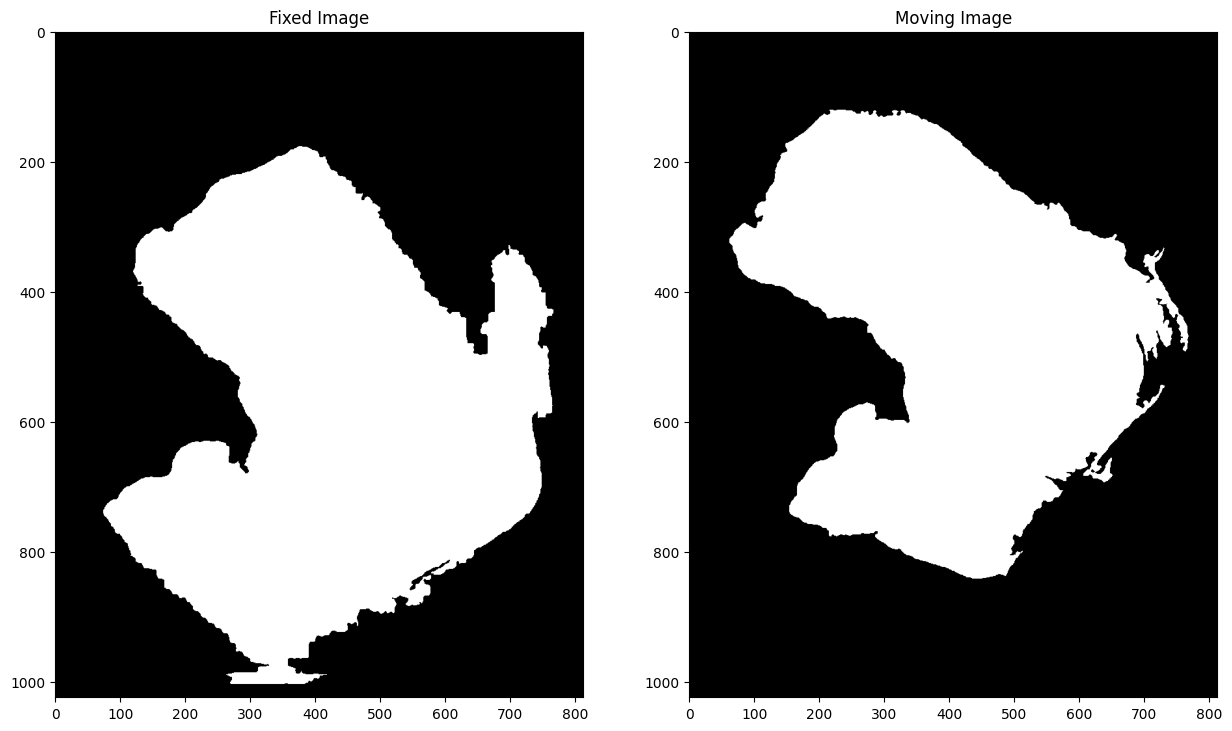

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(fixed_mask, cmap='gray')
axs[0].set_title("Fixed Image")
axs[1].imshow(moving_mask, cmap='gray')
axs[1].set_title("Moving Image")
plt.show()

In [ ]:
save_dir = os.path.join(output_path, str(current_id))
# if os.path.exists(save_dir):
#     shutil.rmtree(save_dir, ignore_errors=False, onerror=None)

segmentor = SemanticSegmentor(
	pretrained_model="unet_tissue_mask_tsef",
	num_loader_workers=4,
	batch_size=4,
)

output = segmentor.predict(
  [os.path.join(save_dir, 'source.png'), os.path.join(save_dir, 'target.png')],
	save_dir=os.path.join(save_dir, 'mask'),
	mode="tile",
	resolution=1.0,
	units="baseline",
	patch_input_shape=[1024, 1024],
	patch_output_shape=[512, 512],
	stride_shape=[512, 512],
	on_gpu=True,
	crash_on_exception=True,
)

|2023-09-11|10:50:37.993| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.


Download from https://tiatoolbox.dcs.warwick.ac.uk/models/registration/UNET-v0.0-TSEF.pth
Save to /home/ivan/.tiatoolbox/models/UNET-v0.0-TSEF.pth


|2023-09-11|10:50:38.493| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
|2023-09-11|10:50:38.501| [WARNING] Raw data is None.
|2023-09-11|10:50:38.501| [WARNING] Unknown scale (no objective_power or mpp)
Process Batch: 100%|##############################| 1/1 [00:01<00:00,  1.09s/it]

|2023-09-11|10:50:39.597| [INFO] Finish: 0
|2023-09-11|10:50:39.597| [INFO] --Input: /data/ANHIR_Parsed_1024_Original/0/source.png
|2023-09-11|10:50:39.598| [INFO] --Output: /data/ANHIR_Parsed_1024_Original/0/mask/0



|2023-09-11|10:50:39.604| [WARNING] Raw data is None.
|2023-09-11|10:50:39.604| [WARNING] Unknown scale (no objective_power or mpp)
Process Batch: 100%|##############################| 1/1 [00:00<00:00,  2.13it/s]

|2023-09-11|10:50:40.079| [INFO] Finish: 0
|2023-09-11|10:50:40.079| [INFO] --Input: /data/ANHIR_Parsed_1024_Original/0/target.png
|2023-09-11|10:50:40.079| [INFO] --Output: /data/ANHIR_Parsed_1024_Original/0/mask/1


In [ ]:
def post_processing_mask(mask):
  mask = ndimage.binary_fill_holes(mask, structure=np.ones((3,3))).astype(int)

  # remove all the objects while keep the biggest object only
  label_img = measure.label(mask)
  if len(np.unique(label_img)) > 2:
    regions = measure.regionprops(label_img)
    mask = mask.astype(bool)
    all_area = [i.area for i in regions]
    second_max = max([i for i in all_area if i != max(all_area)])
    mask = morphology.remove_small_objects(mask, min_size=second_max + 1)
  return mask.astype(np.uint8)

In [ ]:
fixed_mask = np.load(output[0][1] + ".raw.0.npy")
moving_mask = np.load(output[1][1] + ".raw.0.npy")

# Simple processing of the raw prediction to generate semantic segmentation task
fixed_mask = np.argmax(fixed_mask, axis=-1) == 2 
moving_mask = np.argmax(moving_mask, axis=-1) == 2  

fixed_mask = post_processing_mask(fixed_mask)
moving_mask = post_processing_mask(moving_mask)

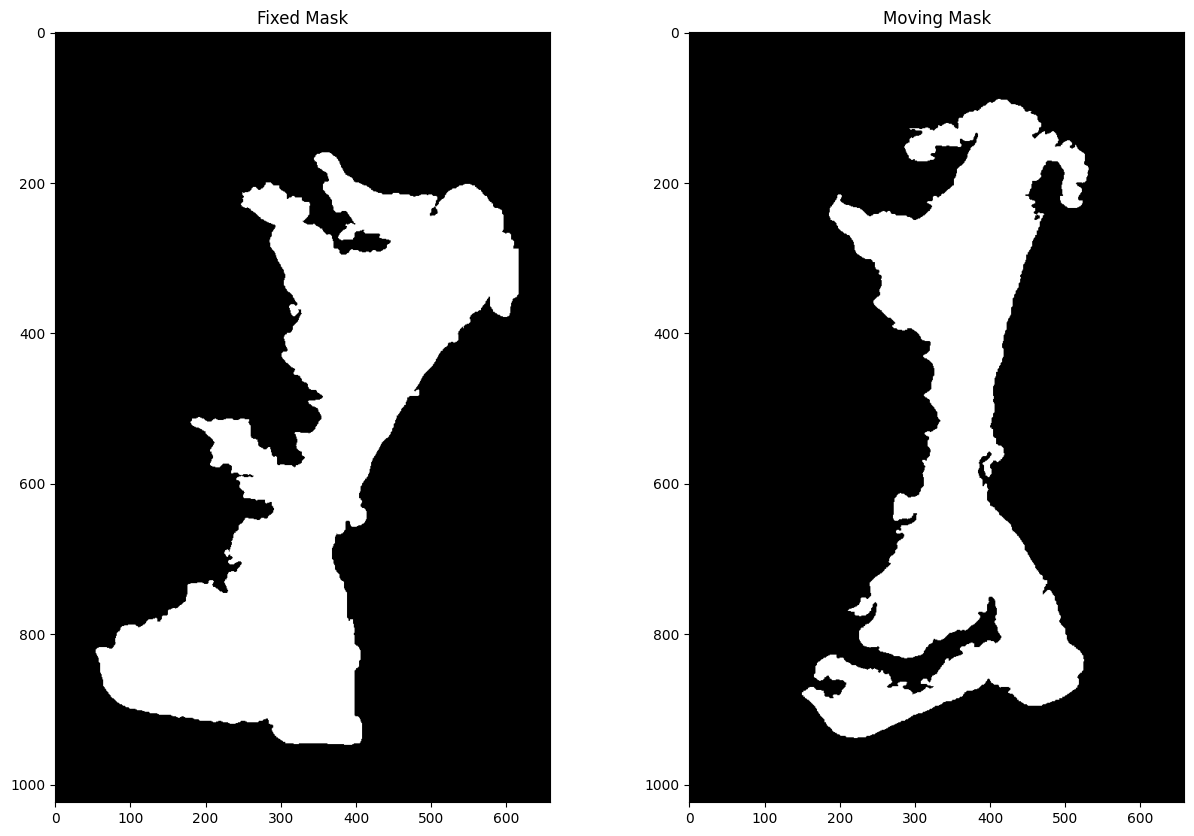

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(fixed_mask, cmap='gray')
axs[0].set_title("Fixed Mask")
axs[1].imshow(moving_mask, cmap='gray')
axs[1].set_title("Moving Mask")
plt.show()